<a href="https://colab.research.google.com/github/emil-freme/supercomp/blob/main/Benchmark_Compiladores_HPC_E_Blocking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os

module_path = "/content/drive/MyDrive/Colab Notebooks/Supercomp/Bench00"
if module_path not in sys.path:
    sys.path.append(module_path)

from helper import *
sns.FacetGrid.apply_hatches = apply_hatches

Benchmark CPU entre compiladores e tecnica de blocagem.
---

Este simples relatório apresenta os resultados do código exemplo da disciplina de Supercomputaçao (https://insper.github.io/supercomp/aulas/aula03/) `matmul_seq.cpp`.

Para o benchmar foram utilizadas as ferramentas dos seguintes _toolings_:
> #### GCC (G++)
> Compilador de código aberto amplamente adotado na comunidade científica e > industrial. É uma referência em portabilidade e compatibilidade, estando presente na maioria das distribuições Linux.

> #### LLVM (Clang++)
>
>  Parte do ecossistema LLVM, destaca-se pela arquitetura modular e pelo tempo de compilação rápido. Suas mensagens de erro detalhadas o tornam também uma ferramenta importante no ensino e no desenvolvimento experimental. Em HPC, vem ganhando espaço pela evolução constante nas otimizações de código vetorizado e paralelizado.

> #### Intel oneAPI (icpx)
>
> Voltado principalmente para processadores Intel, aproveita instruções vetoriais avançadas (como AVX-512) e integrações específicas para HPC.

> #### NVIDIA HPC SDK (nvc++)
>
> Toolkit desenvolvido pela NVIDIA para explorar aceleração em GPUs, com suporte a CUDA, OpenACC e otimizações voltadas a ambientes massivamente paralelos. _No entanto, neste benchmark específico não utilizamos GPU, o que significa que não exploramos todo o potencial do NVIDIA HPC SDK, restringindo sua atuação apenas às otimizações de compilação para CPU._

# Execução local

Na sessão de execução local, o benchmark foi rodado localmente na maquina a seguir descrita.

---

**Sistemal**

| SO    | Distribuição           | Kernel                                   | RAM   | CPU                       | GPU                        |
|:--:|:--:|:--:|:--:|:--:|:--:|
| Linux | Ubuntu 22.04.5 LTS    | 5.15.167.4-microsoft-standard-WSL2     | 31 GiB| Intel(R) Core(TM) <br> i9-9900K| NVIDIA GeForce <br> RTX 2080 |

---

**CPU: Intel(R) Core(TM) i9-9900K**

| Arquitetura | Núcleos físicos | Threads | Sockets | Cache L1d | Cache L1i | Cache L2 | Cache L3 |
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
| x86_64    | 8              | 16      | 1       | 256 KiB ×8 | 256 KiB ×8 | 2 MiB ×8 | 16 MiB ×1 |

---

**GPU: NVIDIA GeForce RTX 2080** <small>(para completude de informação)</small>

| Driver | CUDA  | Memória Total | Memória em Uso | Temperatura | Consumo de Energia |
|:--:|:--:|:--:|:--:|:--:|:--:|
| 560.81 | 12.6  | 8 GiB         | 1.36 GiB       | 38 °C       | 24W / 180W       |

---

**Compiladores Utilizados**

| Compilador / Toolkit | Versão |
|:--:|:--:|
| GCC (g++)            | 11.4.0 |
| LLVM (clang++)       | 14.0.0 |
| Intel oneAPI DPC++/C++ | 2025.2.1 |
| NVIDIA HPC SDK (nvc++) | 25.7-0 |

---

In [2]:
# Carrego o arquivo de resultados que tem as seguinte colunas:
# compiler: CLANG, GCC, INTEL icpx, NVIDIA nvc++
# opt: Opção de Otimização (Base sem flag, OO2 -O2, OO3 -O3)
# case: tamanho do bloco B
# time_ms: tempo em ms executado
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Supercomp/Bench00/benchmark_results.csv")

In [3]:
data = data.rename(columns={
    "compiler": "Compilers",
    "opt": "Optimization Flags",
    "case": "Block Size",
    "time_ms": "Time (ms)"
})

opt = "Optimization Flags"
_case = "Block Size"
time_ms = "Time (ms)"
compiler = "Compilers"

In [4]:
# Visualizaçõa rápida dos dados.
data.head()

,Compilers,Optimization Flags,Block Size,Time (ms)
0,CLANG,Base,0,10602
1,CLANG,OO2,0,950
2,CLANG,OO3,0,1031
3,CLANG,Base,8,10949
4,CLANG,OO2,8,829


# Comparação Inicial

Nesse primeiro momento queremos descobrir do nosso dataset qual o impacto dos  três pontos de observação deste benchmark:

- Diferenças entre compiladores diferentes;
- Uso das flags de otimização (-O2 e -O3);
- Uso de blocagem (tiling/fateamento em blocos)

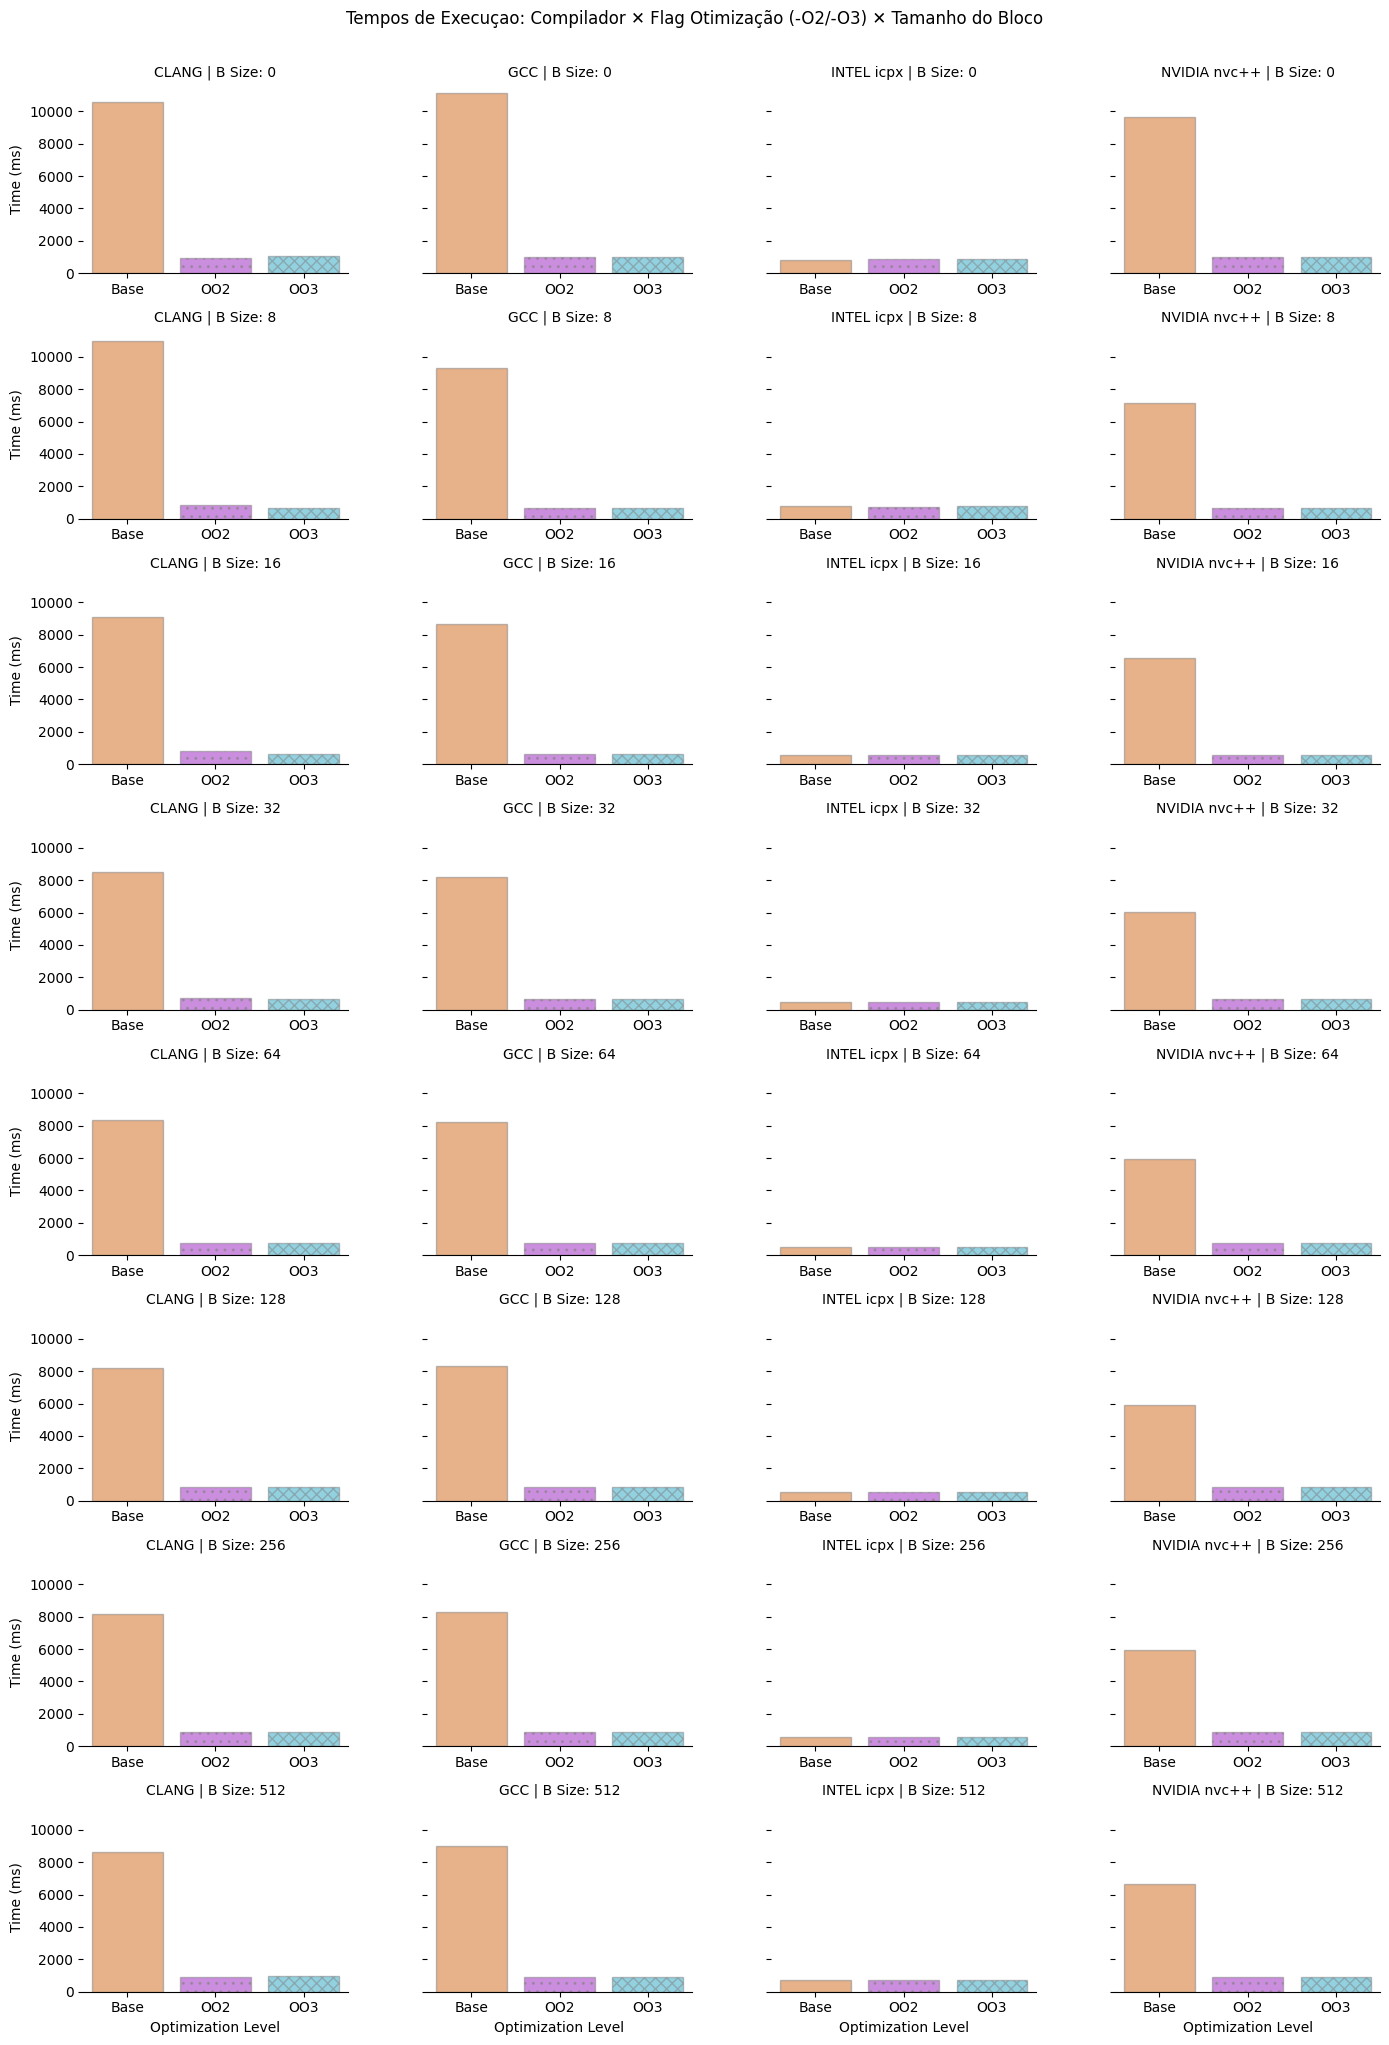

In [5]:
g = sns.catplot(data=data, kind="bar", x=opt, y=time_ms, col=compiler, row=_case, palette=flags_pallete, height=2.5, aspect=1.4, hue=opt)
g.set_axis_labels("Optimization Level", "Time (ms)")
g.set_titles("{col_name} | B Size: {row_name}")
g.despine(left=True)
g.fig.suptitle("Tempos de Execuçao: Compilador ✕ Flag Otimização (-O2/-O3) ✕ Tamanho do Bloco", y=1.02)
g.apply_hatches(flags_hatch)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

Com a excessão do compilador da INTEL, podemos ver claramente que existe grande diferênça entre os tempos de execuçõse de cada compilador relativo às suas flags de otimizaçÕes tanto -O2 como -O3

## Plot Categorico com y não normalizado <small>(Compilador x Tamanho de Bloco) x Flags de otimizações</small>

Esse grafico foi feito para que se possa ter uma maior atenção a ordem de grandeza dos  tempos de processamento.

Perceba que para o compilador  icxp INTEL oneAPItem uma Y na ordem de 800ms(0.8), versus o CLANG que em seu caso base tem o Y MAX em 10000ms (10s)

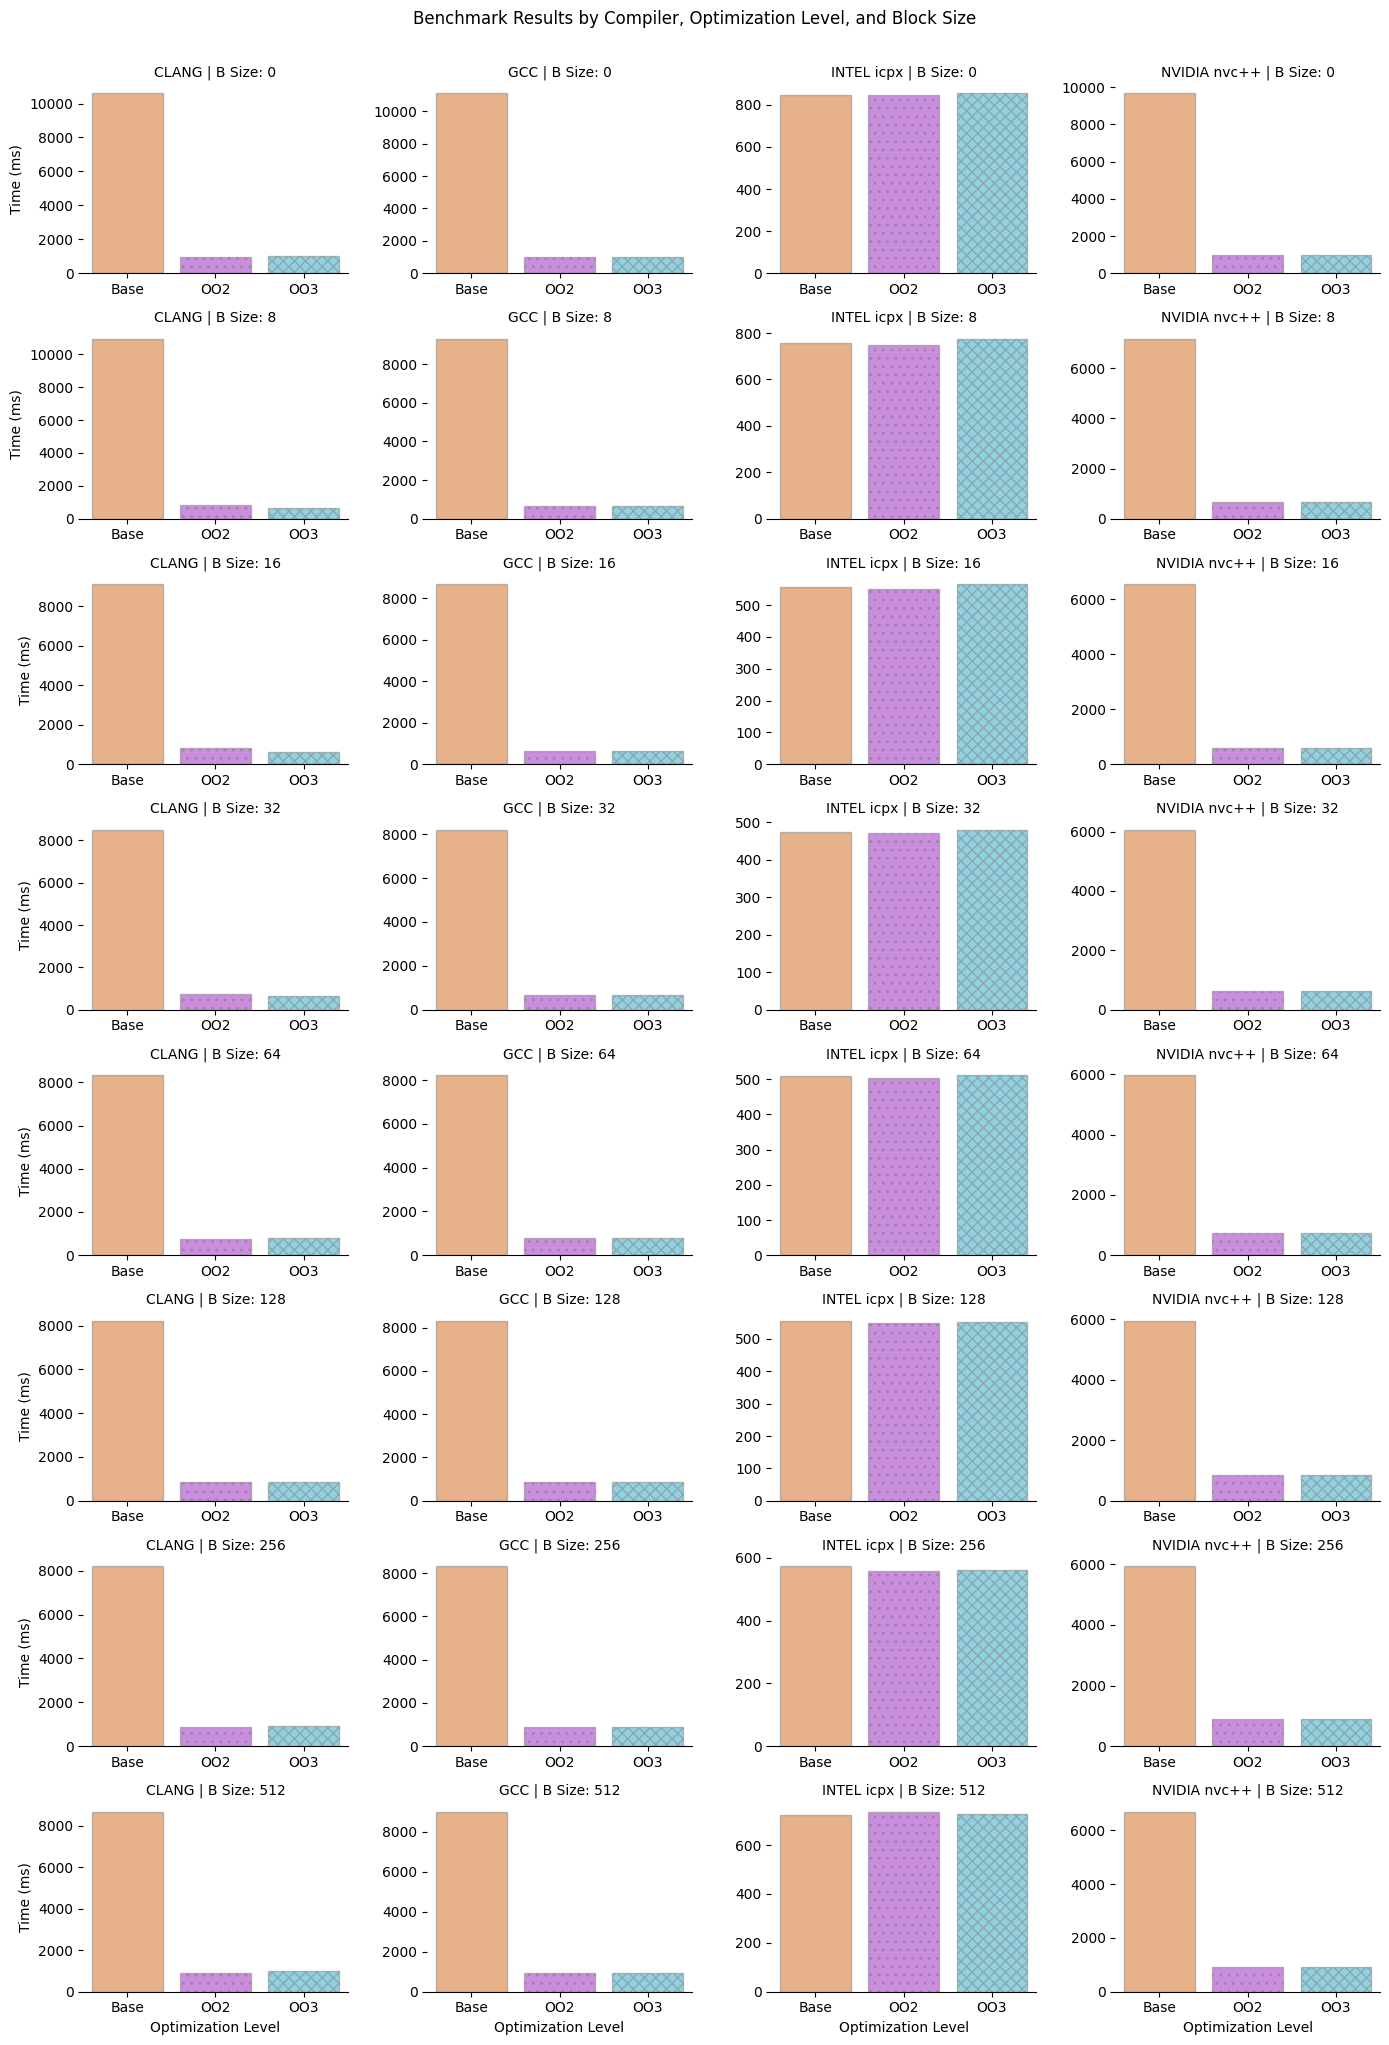

In [6]:
g = sns.catplot(data=data, kind="bar", x=opt, y=time_ms, col=compiler, row=_case, palette=flags_pallete, hue=opt, height=2.5, aspect=1.4, sharey=False)
g.set_axis_labels("Optimization Level", "Time (ms)")
g.set_titles("{col_name} | B Size: {row_name}")
g.despine(left=True)
g.fig.suptitle("Benchmark Results by Compiler, Optimization Level, and Block Size", y=1.02)
g.apply_hatches(flags_hatch)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

## Plot Categorico com y normalizado <small>(Compilador x Tamanho do Bloco) x Flags de otimizações</small>


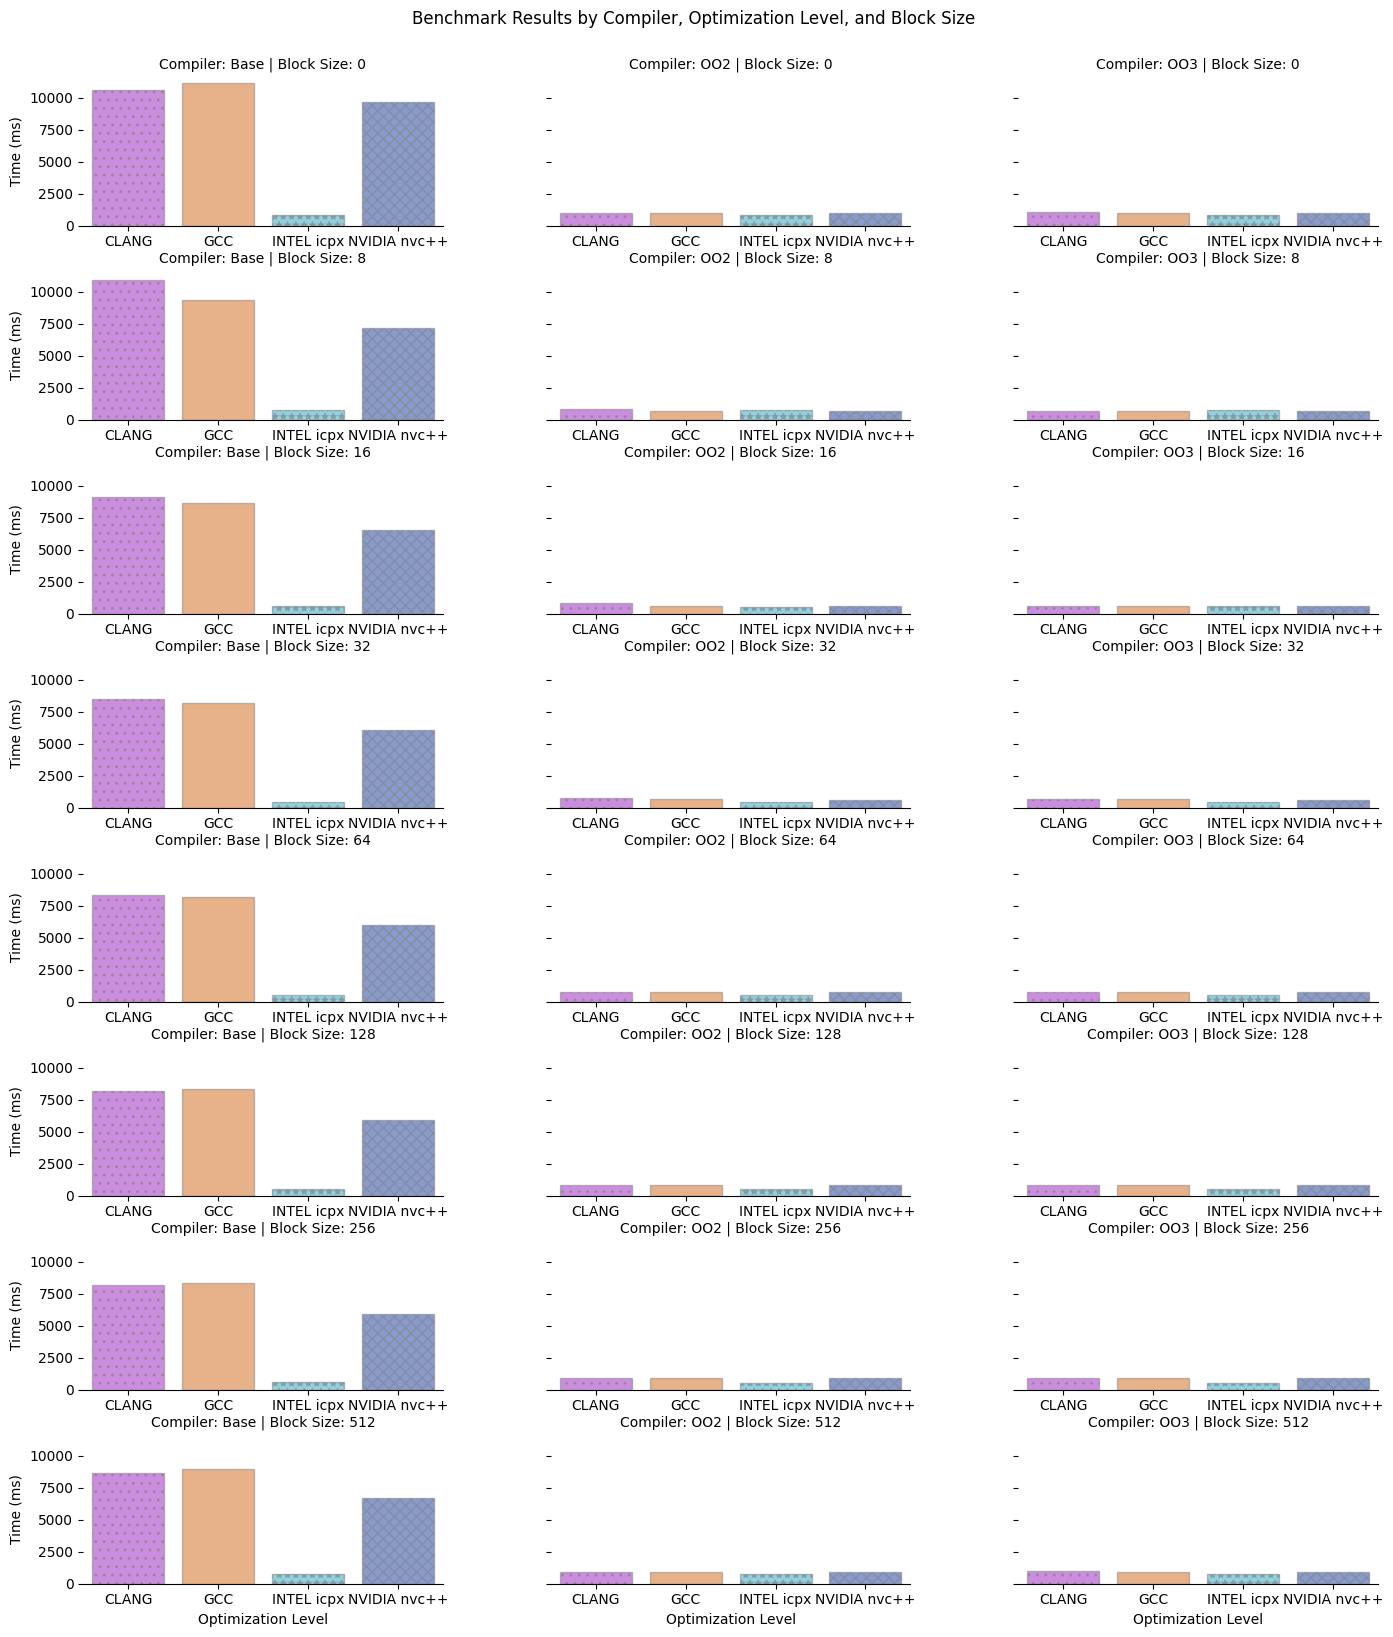

In [7]:
g = sns.catplot(data=data, kind="bar", x=compiler, y=time_ms, col=opt, row=_case, palette=compilers_pallete, hue=compiler, height=2, aspect=2.33)
g.set_axis_labels("Optimization Level", "Time (ms)")
g.set_titles("Compiler: {col_name} | Block Size: {row_name}")
g.despine(left=True)
g.fig.suptitle("Benchmark Results by Compiler, Optimization Level, and Block Size", y=1.02)
g.apply_hatches(compilers_hatch)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

De outra forma conseguimos visualizar o impacto das flags de otimização em cada um dos compiladores.

Para ver como melhor detalhes, vamos remover o caso base:

## Plot Categorico com y não normalizado <small>(Compilador x Tamanho do Bloco) x Flags de otimizações</small>


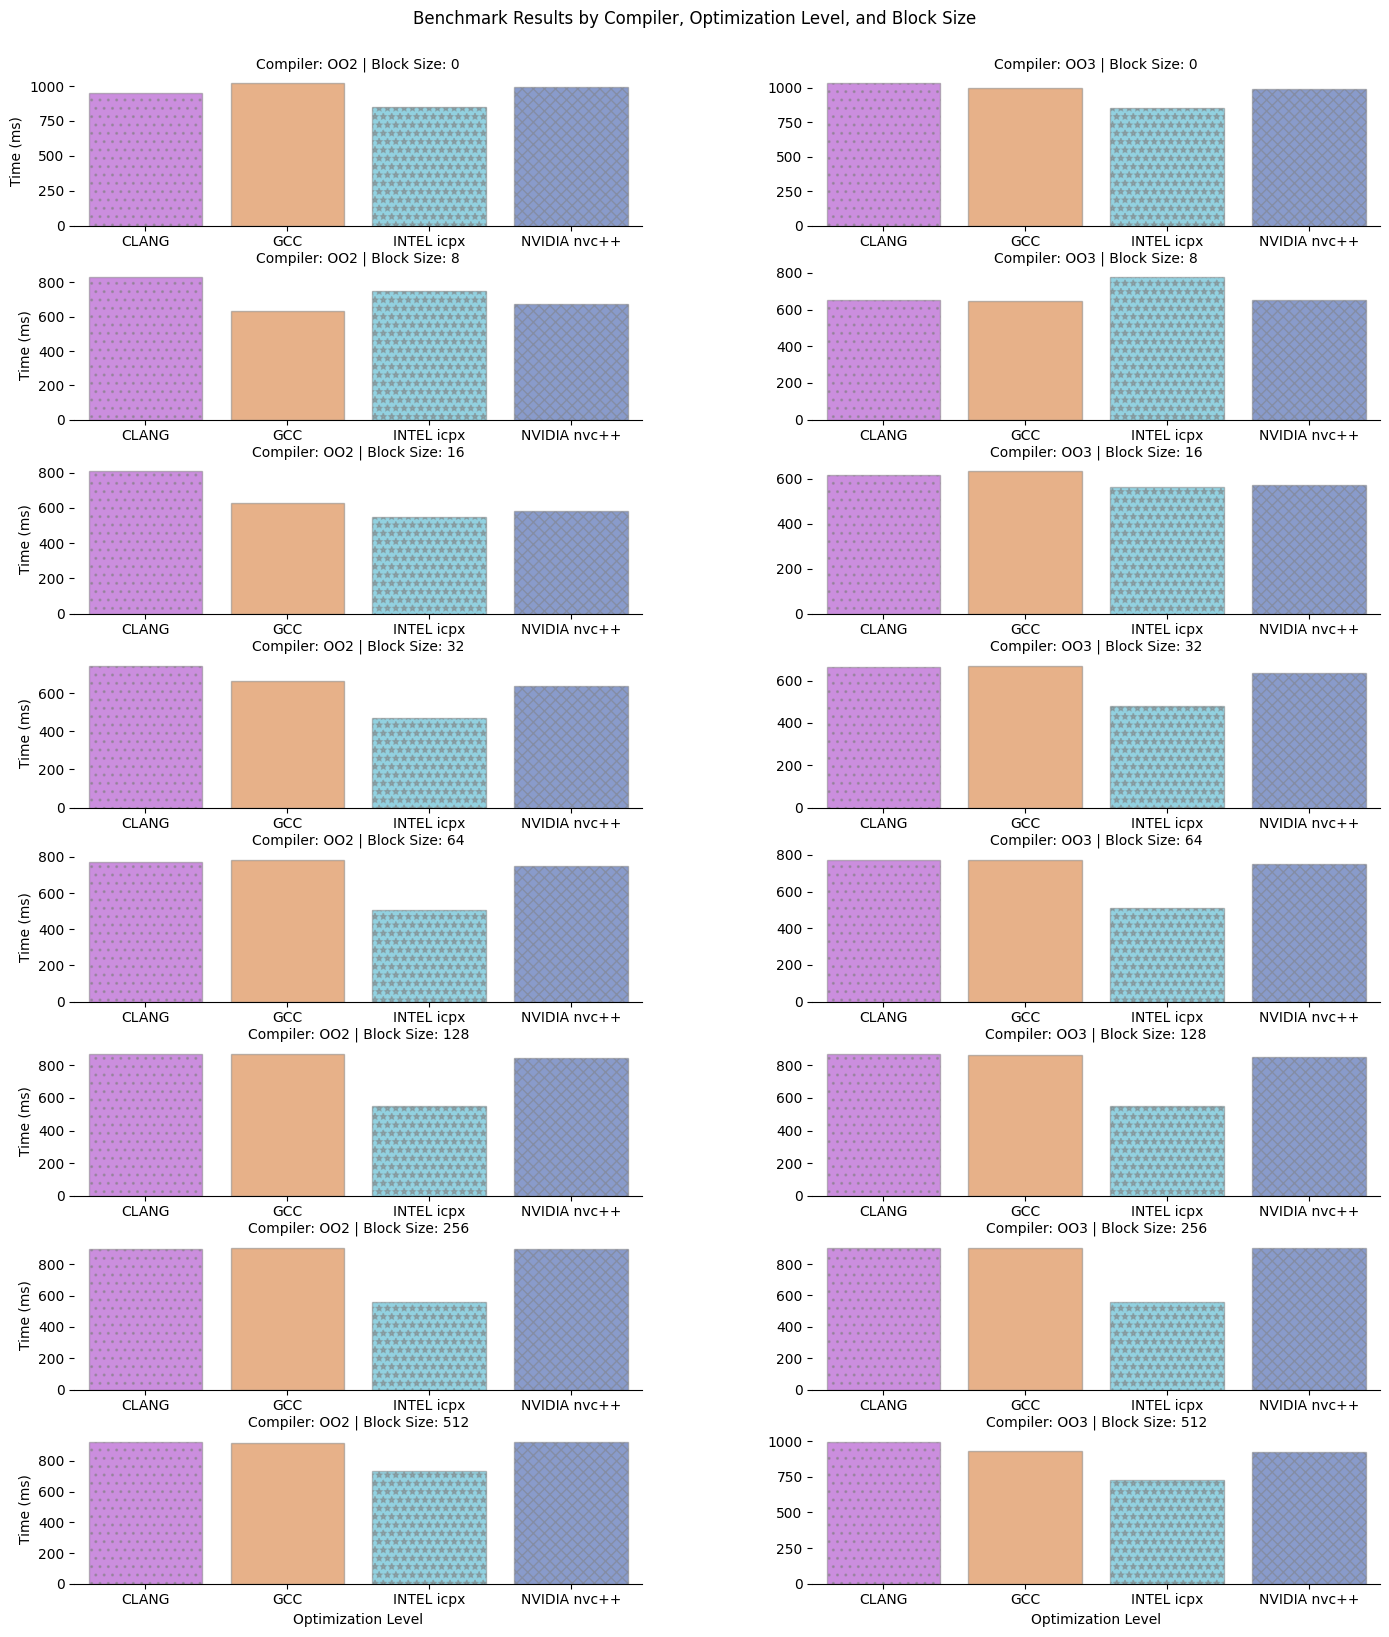

In [8]:
data_no_base = data[data[opt] != 'Base'].copy()
g = sns.catplot(data=data_no_base, kind="bar", x=compiler, y=time_ms, col=opt, row=_case, palette=compilers_pallete, hue=compiler, height=2, aspect=3.5, sharey=False)
g.set_axis_labels("Optimization Level", "Time (ms)")
g.set_titles("Compiler: {col_name} | Block Size: {row_name}")
g.despine(left=True)
g.fig.suptitle("Benchmark Results by Compiler, Optimization Level, and Block Size", y=1.02)
g.apply_hatches(compilers_hatch)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

Ao verificar esse grático percebemos que ao aplicar as flags de otimização e blocking obtemos um ponto ótimo de execução.  

Vamos visualizar de outra forma.

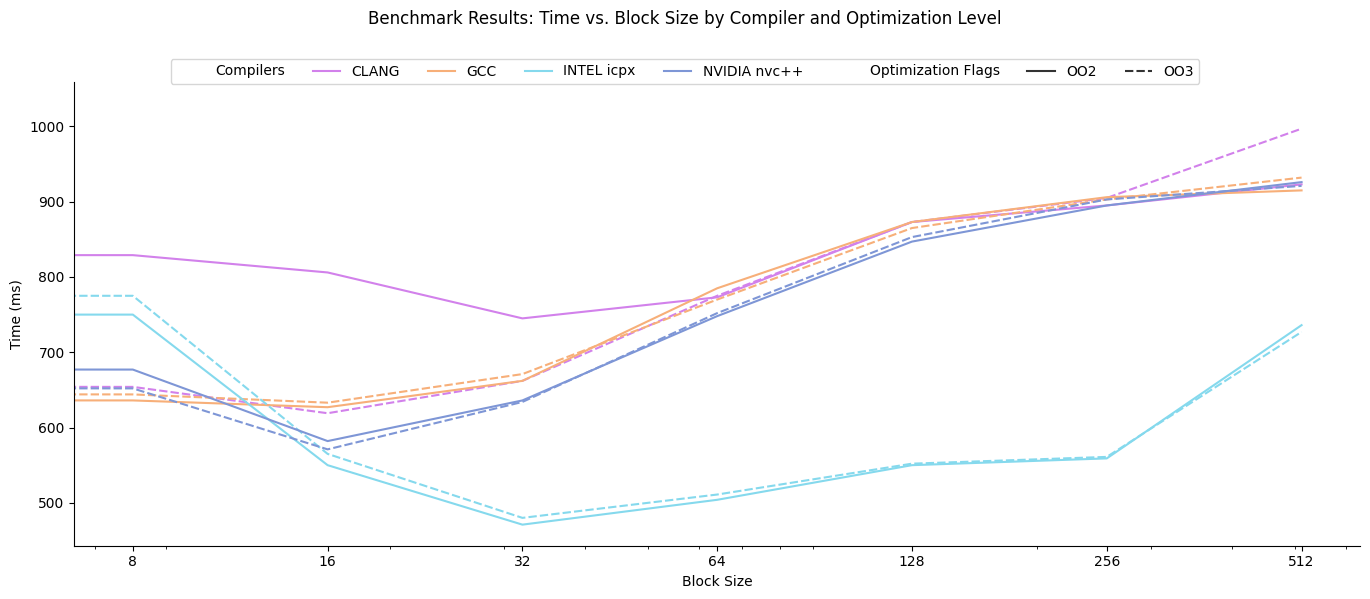

In [9]:
g = sns.relplot(data=data_no_base, kind="line", x=_case, y=time_ms, hue=compiler, style=opt, palette=compilers_pallete, height=6, aspect=2)
g.set_axis_labels("Block Size", "Time (ms)")
g.fig.suptitle("Benchmark Results: Time vs. Block Size by Compiler and Optimization Level", y=1.02)

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
plt.xscale('log')
plt.xticks([8, 16, 32, 64, 128, 256, 512], [8, 16, 32, 64, 128, 256, 512])
g._legend.set_loc('upper center')
g._legend.set_ncols(8)
g._legend.remove()
handles, labels = g.ax.get_legend_handles_labels()
# Create a new legend on the figure, placed below the plot
g.fig.legend(
    handles=handles,  # use the original legend handles
    labels=labels,     # use the original legend labels
    loc='upper center',
    ncol=10,
    bbox_to_anchor=(0.5, 0.95),  # adjust vertical position below the axes
)

Conseguimos observar que existe um "sweetspot" aka ponto ótimo por volta dos tamanhos 16 e 32.  **Por que?**

Mesmo com o Compilador da Intel que já tem um baseline baixo.
Já com o GCC conseguimis ver que exite pouco ganho por volta do ponto ótimo e depois isso se degrada.



# Mas no fim do dia o que isso implica?


Para quantificar o impacto das otimizações, podemos comparar o tempo de execução no ponto ótimo com o tempo de execução do caso Base para cada compilador.

**CLANG:**

| Tamanho do Bloco | Otimização | Tempo (ms) | Tempo Base CLANG (ms) |vs. Próprio | vs. Base GCC |
|-----------------|------------|------------|-----------------------|-------------------------------------|-----------------------------------|
| 16 | -O2 | 806 | 10949 | 92.6% | 91.97% |
| 16 | -O3 | 678 | 10949 | 93.8% | 93.25% |
| 32 | -O2 | 654 | 8409 | 92.2% | 93.49% |
| 32 | -O3 | 654 | 8409 | 92.2% | 93.49% |

**GCC:**

| Tamanho do Bloco | Otimização | Tempo (ms) |  vs. Base GCC |
|-----------------|------------|------------|-----------------------------------|
| 16 | -O2 | 623 | 93.79% |
| 16 | -O3 | 658 | 93.48% |
| 32 | -O2 | 613 | 93.89% |
| 32 | -O3 | 617 | 93.85% |

**INTEL icpx:**

| Tamanho do Bloco | Otimização | Tempo (ms) | Tempo Base INTEL icpx (ms) | vs. Próprio | vs. Base GCC |
|-----------------|------------|------------|----------------------------|------------------------------------------|-----------------------------------|
| 16 | -O2 | 564 | 828 | 31.9% | 94.38% |
| 16 | -O3 | 485 | 828 | 41.4% | 95.17% |
| 32 | -O2 | 503 | 828 | 39.2% | 94.99% |
| 32 | -O3 | 480 | 828 | 42.0% | 95.22% |

**NVIDIA nvc++:**

| Tamanho do Bloco | Otimização | Tempo (ms) | Tempo Base NVIDIA nvc++ (ms) | vs. Próprio | vs. Base GCC |
|-----------------|------------|------------|------------------------------|--------------------------------------------|-----------------------------------|
| 16 | -O2 | 618 | 6686 | 90.8% | 93.85% |
| 16 | -O3 | 614 | 6686 | 90.8% | 93.89% |
| 32 | -O2 | 668 | 6686 | 90.0% | 93.35% |
| 32 | -O3 | 650 | 6686 | 90.3% | 93.52% |

**Melhores Tempos por Compilador:**

| Compilador | Tamanho do Bloco | Otimização | Tempo (ms) | vs. Base GCC |
|--------------|-----------------|------------|------------|-----------------------------------|
| CLANG | 32 | -O2 | 654 | 93.49% |
| GCC | 32 | -O2 | 613 | 93.89% |
| INTEL icpx | 32 | -O3 | 480 | 95.22% |
| NVIDIA nvc++ | 16 | -O3 | 614 | 93.89% |


Essas comparações percentuais destacam a importância da escolha do compilador, do nível de otimização e do tamanho do bloco para obter o melhor desempenho possível. O "sweet spot" do tamanho do bloco é crucial para maximizar os ganhos das otimizações.


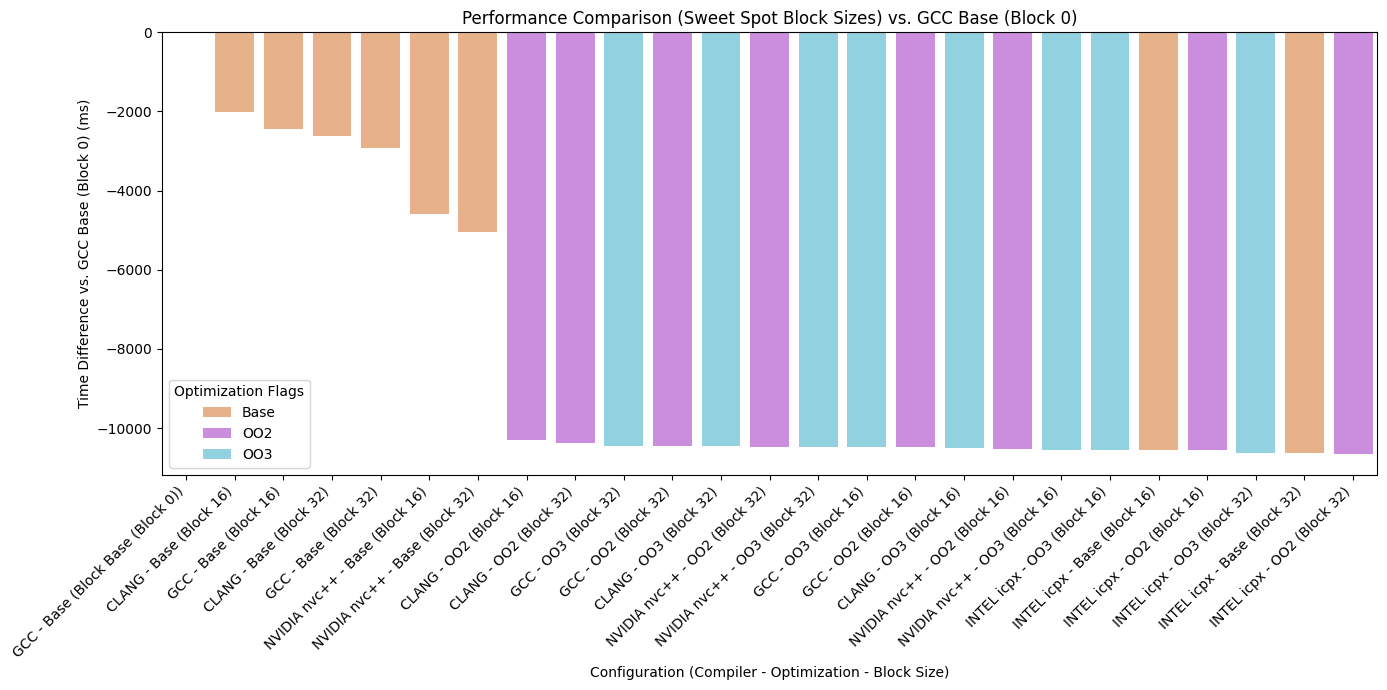

In [15]:
# Filter data for block sizes 16 and 32
sweetspot_data = data[data[_case].isin([16, 32])].copy()

# Find the time for GCC Base case at block 0
gcc_base_time_block_0 = data[(data[compiler] == 'GCC') &
                             (data[opt] == 'Base') &
                             (data[_case] == 0)][time_ms].iloc[0]

# Calculate time difference relative to GCC Base at block 0
sweetspot_data['time_difference_vs_gcc_base_block_0'] = sweetspot_data[time_ms] - gcc_base_time_block_0

# Add the GCC Base case at block 0 to the data for plotting
gcc_base_block_0_row = data[(data[compiler] == 'GCC') &
                            (data[opt] == 'Base') &
                            (data[_case] == 0)].iloc[0].copy()
gcc_base_block_0_row[_case] = 'Base (Block 0)'  # Assign a label for plotting
gcc_base_block_0_row['time_difference_vs_gcc_base_block_0'] = 0  # Difference is 0 for the base case
gcc_base_block_0_row['config'] = 'GCC - Base (Base Case Block 0)'

sweetspot_data = pd.concat([sweetspot_data, pd.DataFrame([gcc_base_block_0_row])], ignore_index=True)

# Create a combined column for plotting
sweetspot_data['config'] = sweetspot_data[compiler] + ' - ' + sweetspot_data[opt] + ' (Block ' + sweetspot_data[_case].astype(str) + ')'

# Order the data by time difference
# Sort by time_difference_vs_gcc_base_block_0 in descending order (more positive is better)
sweetspot_data_ordered = sweetspot_data.sort_values('time_difference_vs_gcc_base_block_0', ascending=False)

# Create the bar plot
plt.figure(figsize=(14, 7))
sns.barplot(data=sweetspot_data_ordered, x='config', y='time_difference_vs_gcc_base_block_0', palette=flags_pallete, hue=opt)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Time Difference vs. GCC Base (Block 0) (ms)")
plt.xlabel("Configuration (Compiler - Optimization - Block Size)")
plt.title("Performance Comparison (Sweet Spot Block Sizes) vs. GCC Base (Block 0)")
plt.tight_layout()
plt.show()


Na visão geral das flags de otimização dos compiladores, observa-se que todas proporcionam reduções de desempenho muito semelhantes, indicando que as diferentes opções de otimização tendem a afetar o tempo de execução de maneira uniforme. Isso sugere que, apesar das particularidades de cada compilador e de suas respectivas flags, o impacto no desempenho final costuma seguir uma tendência consistente.

Para aprofundar essa análise, vamos refinar o foco da avaliação removendo os casos em que não há aplicação de flags de otimização, ou seja, aqueles considerados como baseline ou sem otimização.

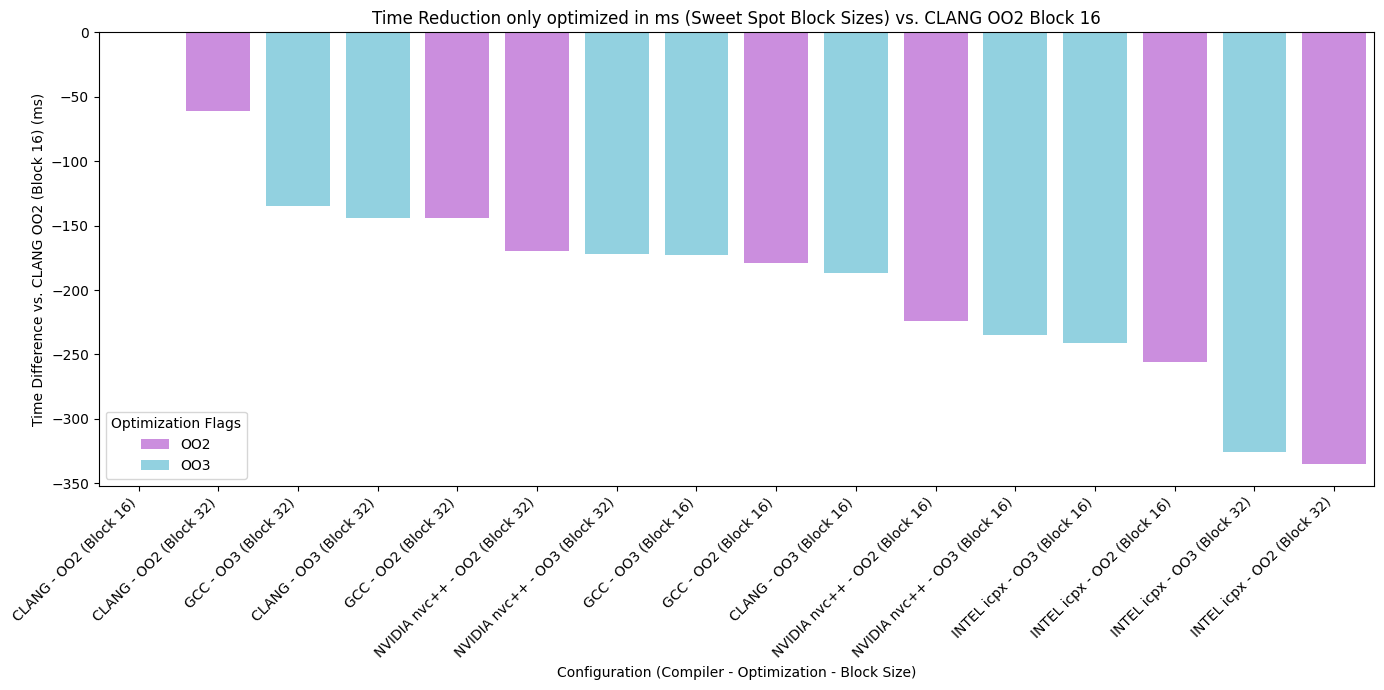

In [16]:
sweetspot_data_no_base = data[(data[opt] != 'Base') & (data[_case].isin([16, 32]))].copy()

clang_OO2_time_block_16 = data[(data[compiler] == 'CLANG') & (data[opt] == 'OO2') & (data[_case] == 16)][time_ms].iloc[0]

sweetspot_data_no_base['time_difference_vs_clang_oo2_16_time'] = sweetspot_data_no_base[time_ms] - clang_OO2_time_block_16

sweetspot_data_no_base['config'] = sweetspot_data_no_base[compiler] + ' - ' + sweetspot_data_no_base[opt] + ' (Block ' + sweetspot_data_no_base[_case].astype(str) + ')'

sweetspot_data_ordered = sweetspot_data_no_base.sort_values('time_difference_vs_clang_oo2_16_time', ascending=False)

plt.figure(figsize=(14, 7))
sns.barplot(data=sweetspot_data_ordered, x='config', y='time_difference_vs_clang_oo2_16_time', palette=flags_pallete, hue=opt)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Time Difference vs. CLANG OO2 (Block 16) (ms)")
plt.xlabel("Configuration (Compiler - Optimization - Block Size)")
plt.title("Time Reduction only optimized in ms (Sweet Spot Block Sizes) vs. CLANG OO2 Block 16")
plt.tight_layout()
plt.show()


É possivel observar aqui, quea ainda temos uma diferença de aproximadamente 350 ms entre nossos melhore tempos.

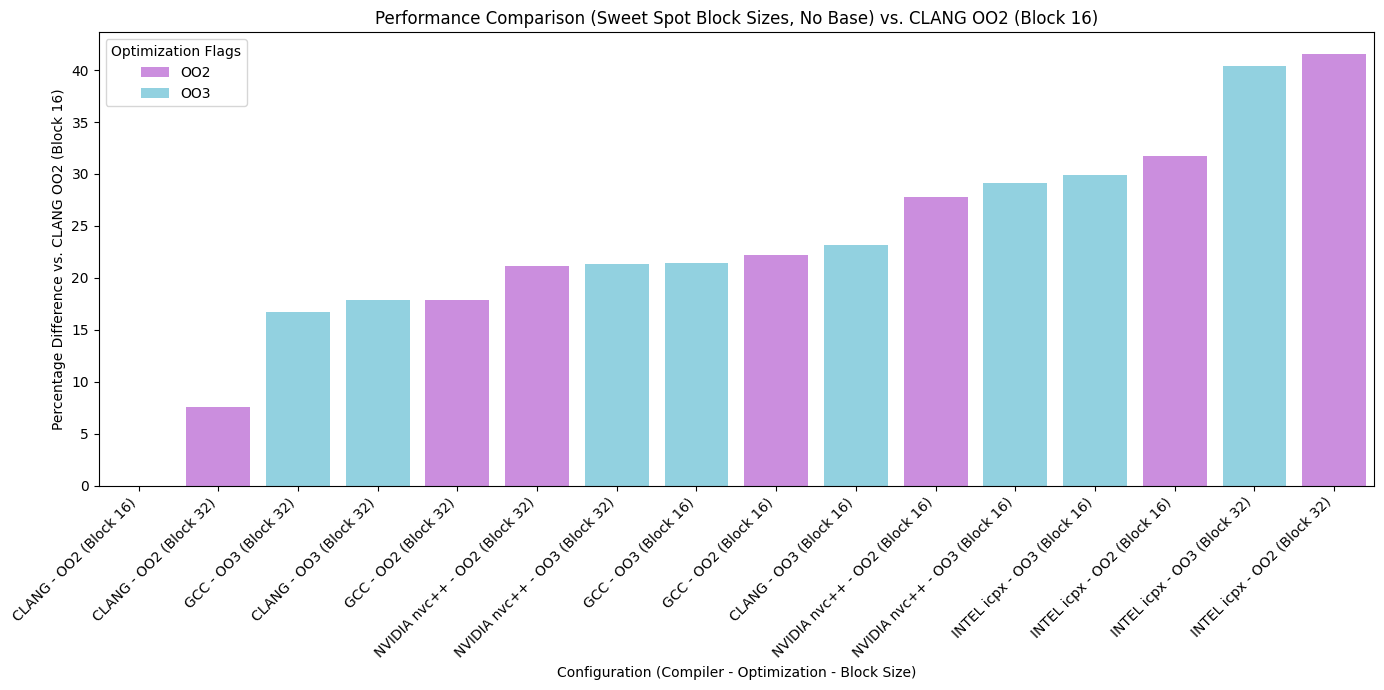

In [17]:
# Calculate percentage difference relative to clang_OO2_time_block_16
clang_OO2_time_block_16 = data[(data[compiler] == 'CLANG') & (data[opt] == 'OO2') & (data[_case] == 16)][time_ms].iloc[0]

sweetspot_data_no_base['percentage_difference_vs_clang_oo2_16'] = ((clang_OO2_time_block_16 - sweetspot_data_no_base[time_ms]) / clang_OO2_time_block_16) * 100

# Create a combined column for plotting
sweetspot_data_no_base['config'] = sweetspot_data_no_base[compiler] + ' - ' + sweetspot_data_no_base[opt] + ' (Block ' + sweetspot_data_no_base[_case].astype(str) + ')'

# Order the data by percentage difference
sweetspot_data_ordered = sweetspot_data_no_base.sort_values('percentage_difference_vs_clang_oo2_16')

# Create the bar plot
plt.figure(figsize=(14, 7))
sns.barplot(data=sweetspot_data_ordered, x='config', y='percentage_difference_vs_clang_oo2_16', palette=flags_pallete, hue=opt)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Percentage Difference vs. CLANG OO2 (Block 16)")
plt.xlabel("Configuration (Compiler - Optimization - Block Size)")
plt.title("Performance Comparison (Sweet Spot Block Sizes, No Base) vs. CLANG OO2 (Block 16)")
plt.tight_layout()
plt.show()


"Mas eu já estou num ponto ótimo, com as otimizações já conseguimos ordens de grandeza em performance, o que esses 40% apenas nos nossos programas mais rápidos representam para HPC, é apenas 3% sobre o total, afinal já está muito bom não?"

Depende do que você chama de "muito bom" no universo da Supercomputação! 😂


Ss ganhos iniciais saindo do caso Base para as otimizações (-O2, -O3 e o blocking no "sweetspot") são brutais. A gente viu ali a redução de tempo na casa dos 90% em vários casos. Isso já é um salto gigantesco!

Mas em HPC, a busca por performance é um jogo de centavos, ou melhor, de milissegundos e frações percentuais. Aqueles 40% de diferença entre o INTEL icpx e o CLANG ou GCC no ponto ótimo podem não parecer tão gritantes quanto a diferença do Base para o otimizado, mas o impacto em larga escala continua sendo enorme.

Pensa num cenário de pesquisa científica ou desenvolvimento industrial que depende de milhares ou milhões de horas de processamento em um cluster.
> __Cada 1% de ganho de performance se traduz em centenas ou milhares de horas economizadas ao longo do tempo.__

Isso significa que um pesquisador pode rodar mais simulações, explorar mais hipóteses, obter resultados mais rápido e acelerar a descoberta ou o desenvolvimento de novos produtos/tecnologias.

Além disso, em ambientes de cluster, o custo do tempo de processamento é real e muitas vezes alto. Reduzir o tempo de execução em 40% em um código que roda por muito tempo pode representar uma economia financeira considerável.

E isso ainda nem falamos em paralelização e outras técnicas.

# Execução Cluster/Slurm
TODO